In [ ]:
from __future__ import print_function
import torch
from utils import Plotting,accuracy_plotting
from model import model_1,model_2,model_3,model_4,model_summary
#from model import model_1,model_summary
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28))
                                       #transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       #transforms.RandomRotation((-15., 15.), fill=1),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #rightness=0.10, contrast=0.1,transforms.ColorJitter(b saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


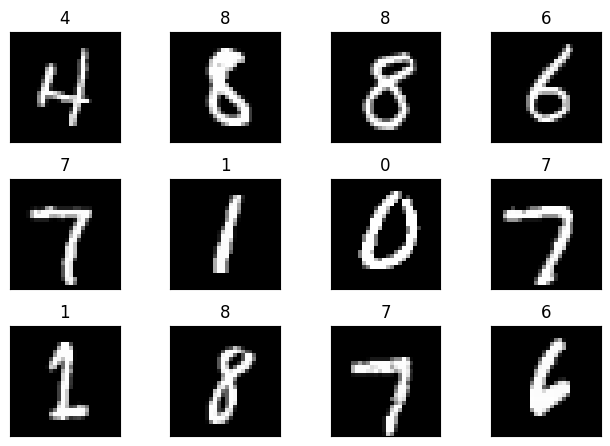

In [ ]:
Plotting(train_loader)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model2 = model_2().to(device)
model_summary(model2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4            [-1, 8, 28, 28]             584
              ReLU-5            [-1, 8, 28, 28]               0
       BatchNorm2d-6            [-1, 8, 28, 28]              16
            Conv2d-7            [-1, 8, 28, 28]             584
              ReLU-8            [-1, 8, 28, 28]               0
       BatchNorm2d-9            [-1, 8, 28, 28]              16
        MaxPool2d-10            [-1, 8, 14, 14]               0
          Dropout-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 12, 14, 14]             876
             ReLU-13           [-1, 12, 14, 14]               0
      BatchNorm2d-14           [-1, 12,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.12406190484762192 Batch_id=468 Accuracy=91.69: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.1224, Accuracy: 9764/10000 (97.64%)

EPOCH: 1


Loss=0.09547001868486404 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0711, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.03460640087723732 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.0496, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.12912680208683014 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.0507, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.047074005007743835 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0403, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.03058205358684063 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]



Test set: Average loss: 0.0316, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.043581146746873856 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:19<00:00, 24.20it/s]



Test set: Average loss: 0.0354, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


Loss=0.024509407579898834 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0298, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.10586953163146973 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]



Test set: Average loss: 0.0263, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.05548056587576866 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0293, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.041813481599092484 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0255, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.01372800674289465 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]



Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.07623279839754105 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0355, Accuracy: 9904/10000 (99.04%)

EPOCH: 13


Loss=0.04303353652358055 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:19<00:00, 23.81it/s]



Test set: Average loss: 0.0291, Accuracy: 9913/10000 (99.13%)

EPOCH: 14


Loss=0.03912390395998955 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]



Test set: Average loss: 0.0267, Accuracy: 9925/10000 (99.25%)



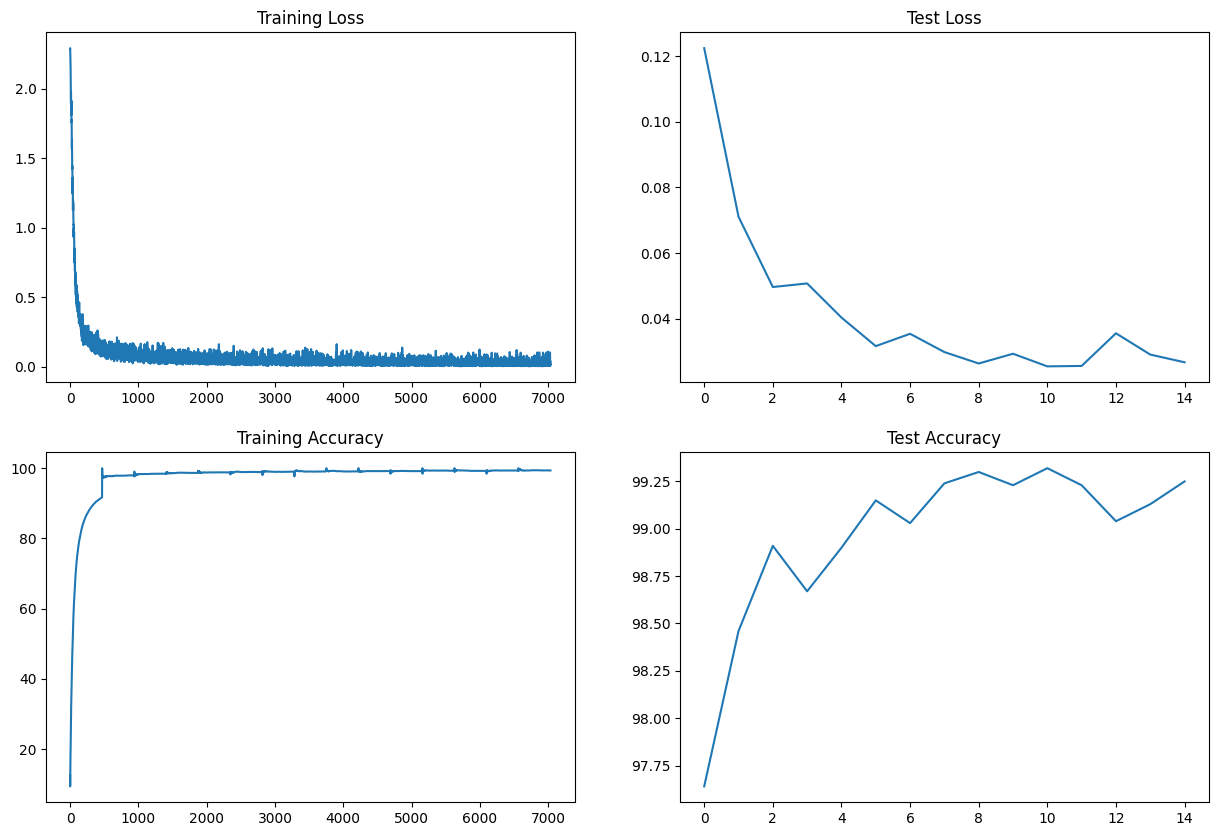

In [ ]:
accuracy_plotting(train_losses,train_acc,test_losses,test_acc)